参考：
- http://aidiary.hatenablog.com/entry/20180304/1520172429
- https://github.com/cross32768/VGAN/blob/master/VGAN.ipynb

In [1]:
import os
import pickle
import numpy as np
from tqdm import tqdm
from tensorboardX import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [4]:
def train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter):

    # 本物のラベルは1
    y_real = torch.ones(batch_size, 1)
    # 偽物のラベルは0
    y_fake = torch.zeros(batch_size, 1)
    
    y_real = y_real.to(device)
    y_fake = y_fake.to(device)

    D_running_loss = 0
    G_running_loss = 0
    
    for batch_idx, (real_images, _) in enumerate(tqdm(data_loader)):
        # 訓練モードへ
        D.train()
        G.train()
        
        z = torch.rand((batch_size, z_dim))
        real_images, z = real_images.to(device), z.to(device)

        # Discriminatorの更新
        D_optimizer.zero_grad()

        # Discriminatorにとって本物画像の認識結果は1（本物）に近いほどよい
        # E[log(D(x))]
        D_real, mean, logvar = D(real_images)
        D_real_loss, loss_kldiv_real = D_criterion(D_real, y_real, mean, logvar, beta)

        # DiscriminatorにとってGeneratorが生成した偽物画像の認識結果は0（偽物）に近いほどよい
        # E[log(1 - D(G(z)))]
        # fake_imagesを通じて勾配がGに伝わらないようにdetach()して止める
        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images.detach()) # ここはdetachする。
        D_fake_loss, loss_kldiv_fake = D_criterion(D_fake, y_fake, mean, logvar, beta)

        # 2つのlossの和を最小化する
        D_loss = D_real_loss + D_fake_loss
        D_loss.backward()
        D_optimizer.step()
        D_running_loss += D_loss.item()

        # -------------------------------- ここから
        loss_kldiv = loss_kldiv_real.item() + loss_kldiv_fake.item()
        beta = max(0.0, beta + alpha * loss_kldiv)
        # -------------------------------- ここまで
        
        # Generatorの更新
        z = torch.rand((batch_size, z_dim))
        z = z.to(device)

        G_optimizer.zero_grad()

        fake_images = G(z)
        D_fake, mean, logvar = D(fake_images) # Dに判別してもらう！
        G_loss = G_criterion(D_fake, y_real) # 本物が多いとloss小。
        G_loss.backward()
        G_optimizer.step()
        G_running_loss += G_loss.item()
        
        # TensorBoardX
        writer.add_scalar('train_G_loss', G_loss.item(), num_iter)
        writer.add_scalar('train_D_loss', D_loss.item(), num_iter)
        writer.add_scalar('beta', beta, num_iter)
        if num_iter % 50 == 0:
            G.eval()
            sample_z = torch.rand((64, z_dim)).to(device)
            with torch.no_grad():
                sample = G(sample_z).to('cpu')
            writer.add_image('Image_from_latent', make_grid(sample, nrow=8, padding=1), num_iter)
        num_iter += 1
    
    D_running_loss /= len(data_loader)
    G_running_loss /= len(data_loader)
    
    return D_running_loss, G_running_loss, num_iter, beta

In [5]:
def generate(epoch, G, log_dir='logs'):
    G.eval()
    
    os.makedirs(log_dir, exist_ok=True)

    sample_z = torch.rand((64, z_dim))
    sample_z = sample_z.to(device)
    
    with torch.no_grad():
        samples = G(sample_z).to('cpu')
    save_image(samples, os.path.join(log_dir, 'epoch_%03d.png' % (epoch)))

In [6]:
# hyperparameters
batch_size = 128
lr = 0.0002
z_dim = 62
num_epochs = 100
sample_num = 16
log_dir = './logs/vgan'

In [7]:
# load dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = datasets.MNIST('data/mnist', train=True, download=True, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

(-0.5, 145.5, 145.5, -0.5)

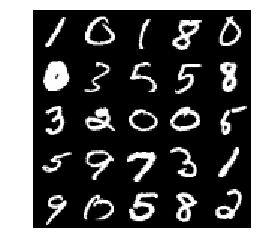

In [8]:
# データの可視化
def imshow(img):
    npimg = img.numpy()
    # [c, h, w] => [h, w, c]
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

images, labels = iter(data_loader).next()
images, labels = images[:25], labels[:25]
imshow(make_grid(images, nrow=5, padding=1))
plt.axis('off')

In [9]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(62, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(),
        )
        
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )
        
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, 7, 7)
        x = self.deconv(x)
        return x

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # 1x28x28
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), # -> 64x32x32
#             nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), # -> 128x16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        )
        
        # -------------------------------- ここから
        self.conv_mus = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        self.conv_sigmas = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0) # -> 128x7x7
        # -------------------------------- ここまで
        
        initialize_weights(self)
    
    def forward(self, input):
        x = self.conv(input)
        
        # -------------------------------- ここから
        mus = self.conv_mus(x).view(-1, 128 * 7 * 7) # mean
        sigmas = self.conv_sigmas(x).view(-1, 128 * 7 * 7) # logvar
        noise = torch.randn(mus.size(), device=device)
        z = noise * sigmas + mus
#         z = (0.5 * sigmas).exp() * noise + mus
        # -------------------------------- ここまで
        
        x = self.fc(z)
        return x, mus, sigmas
#         x = x.view(-1, 128 * 7 * 7) 
#         x = self.fc(x)
#         return x, 0, 0

In [10]:
# initialize network
G = Generator().to(device)
D = Discriminator().to(device)

# optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

# -------------------------------- ここから
I_c = 0.2
beta = 1.0
alpha = 1e-5

# def VDB_loss(out, label, mus, sigmas, beta):
def VDB_loss(out, label, mean, sigma, beta):
    normal_D_loss = F.binary_cross_entropy(out, label)
    
#     kldiv_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
#     kldiv_loss = 0.5 * torch.sum(logvar.exp() + mean.pow(2) - logvar - 1)
    kldiv_loss = 0.5 * torch.sum(mean.pow(2) + sigma.pow(2) - (sigma.pow(2)+1e-8).log() - 1)
    kldiv_loss = kldiv_loss.mean() - I_c
    final_loss = normal_D_loss + beta * kldiv_loss
    
    return final_loss, kldiv_loss.detach()
#     return F.binary_cross_entropy(out, label), 0
# -------------------------------- ここまで

G_criterion = nn.BCELoss()
D_criterion = VDB_loss

In [11]:
# D = Discriminator().to(device)
# input = torch.rand((32, 3, 64, 64)).to(device)
# out, mean, logvar = D(input)
# # print(out.size(), mean.size(), logvar.size())

In [12]:
writer = SummaryWriter()

history = {}
history['D_loss'] = []
history['G_loss'] = []
num_iter = 0

for epoch in range(num_epochs):
    D_loss, G_loss, num_iter, beta = train(D, G, D_criterion, G_criterion, D_optimizer, G_optimizer, data_loader, beta, writer, num_iter)
    
    print('epoch %d, D_loss: %.4f G_loss: %.4f' % (epoch + 1, D_loss, G_loss))
    history['D_loss'].append(D_loss)
    history['G_loss'].append(G_loss)
    
    # Generatorから画像を生成してモデルも保存
    generate(epoch + 1, G, log_dir)
    torch.save(G.state_dict(), os.path.join(log_dir, 'G_%03d.pth' % (epoch + 1)))
    torch.save(D.state_dict(), os.path.join(log_dir, 'D_%03d.pth' % (epoch + 1)))

  0%|          | 2/468 [00:00<00:24, 18.90it/s]

epoch 1, D_loss: 592778321.4380 G_loss: 0.6974


  0%|          | 2/468 [00:00<00:23, 19.88it/s]

epoch 2, D_loss: 134516827.7607 G_loss: 0.6936


  0%|          | 2/468 [00:00<00:25, 18.62it/s]

epoch 3, D_loss: 89583847.8974 G_loss: 0.6935


  0%|          | 2/468 [00:00<00:23, 19.91it/s]

epoch 4, D_loss: 66583709.2991 G_loss: 0.6933


  0%|          | 2/468 [00:00<00:23, 19.92it/s]

epoch 5, D_loss: 56375500.0000 G_loss: 0.6933


  1%|          | 3/468 [00:00<00:22, 20.91it/s]

epoch 6, D_loss: 51401901.3248 G_loss: 0.6933


  1%|          | 3/468 [00:00<00:22, 20.43it/s]

epoch 7, D_loss: 48680413.8376 G_loss: 0.6933


 35%|███▍      | 163/468 [00:08<00:15, 19.72it/s]


KeyboardInterrupt: 

In [ ]:
D_loss, G_loss = history['D_loss'], history['G_loss']
plt.plot(D_loss, label='D_loss')
plt.plot(G_loss, label='G_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

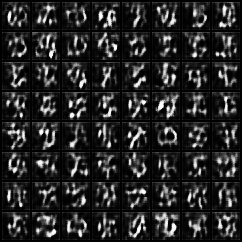

In [16]:
from IPython.display import Image
Image('logs/vgan/epoch_001.png')

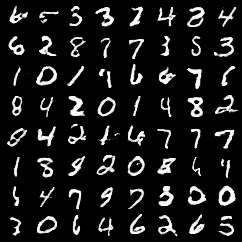

In [17]:
Image('logs/vgan/epoch_010.png')